<a href="https://colab.research.google.com/github/sanmayphy/course-v3/blob/master/GraphNNHomework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset : Protein-Protein Interaction Data

### Each graph : an unique human tissue

### Each node (a protein) : 50 features assigned from positional gene sets,
 ### motif gene sets and immunological signatures data. 

### Label at each node : Each protein is labeled by a sequence of 121 numbers
### (0 or 1)  called gene ontology sets. 

### Ref : https://arxiv.org/pdf/1706.02216.pdf   section 4.2

### The labels are assigned using the algorithm : https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1941744/

# What is the goal of the exercise ? 

## To build a graph neural network which will learn the gene ontology  (GO) ID's of each of the protein in a human cell and will predict the average ID's .

In [0]:
import numpy as np
import torch

## Installing the DGL library

In [2]:
pip install dgl

     |████████████████████████████████| 747kB 7.2MB/s 


In [0]:
import networkx as nx
import dgl


### Download the PPID Dataset : https://github.com/williamleif/GraphSAGE/tree/master/example_data

In [0]:
from dgl.data import PPIDataset

In [5]:
data_train, data_valid, data_test = PPIDataset('train'), PPIDataset('valid'), PPIDataset('test')

Extracting file to /root/.dgl/ppi
Loading G...
Loading G...
Loading G...


## How the induvidual dataset looks like ?

In [6]:
len(data_train), len(data_valid), len(data_test)

(20, 2, 2)

## Structure of the dataset

In [8]:
data_train[0]

(DGLGraph(num_nodes=1767, num_edges=34085,
          ndata_schemes={}
          edata_schemes={}),
 array([[-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        ...,
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485],
        [-0.0855143 , -0.08837446, -0.11277995, ..., -0.1398976 ,
         -0.14936616, -0.14811485]]),
 array([[1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]))

## Each element of the dataset is a tuple : a graph, the features on each nodes, the GO ID on each node

### The number of nodes change in each graph (a human tissue), but number of features assigned to each node (50) remains the same. 
### Similarly each protein comes with an unique GO ID. ( a sequence of 121 numbers consists of 0,1 )

In [10]:
data_train[0][1].shape, data_train[0][2].shape,  data_train[3][1].shape, data_train[3][2].shape

((1767, 50), (1767, 121), (2339, 50), (2339, 121))

### A look into graph structure 

In [11]:
data_train[0][0]

DGLGraph(num_nodes=1767, num_edges=34085,
         ndata_schemes={}
         edata_schemes={})

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10,10

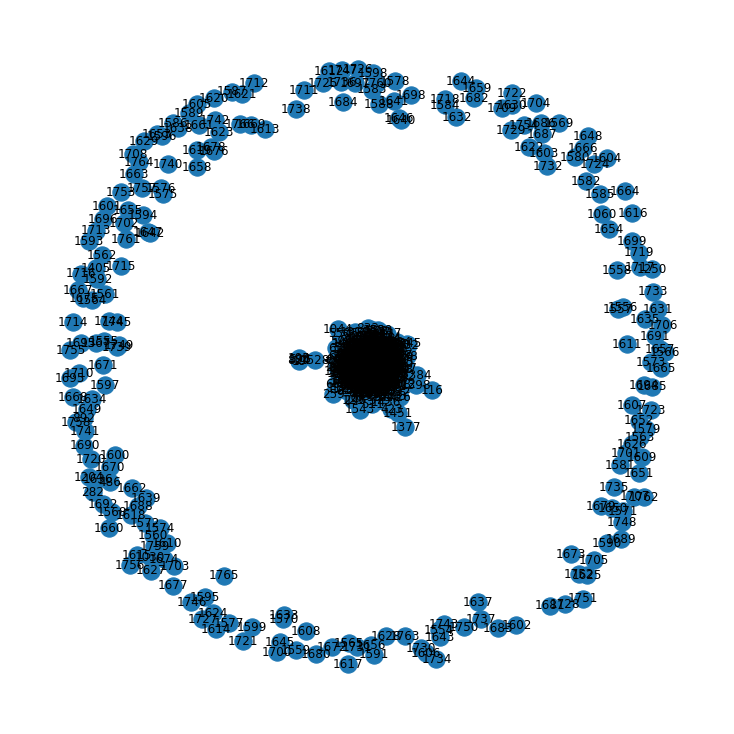

In [13]:
nx.draw(data_train[0][0].to_networkx(), with_labels=True)
plt.show()

### Use a function to assign features to the nodes and make tuples of (graph, node-labels)

In [0]:
def ProcessGraph(data) : 
  
  dataset = []
  n_graph = len(data)
  
  for i_graph in range(n_graph) : 
    
    graph = data[i_graph][0]
    
    graph.ndata['x'] = torch.from_numpy(data[i_graph][1])
    
    label = torch.from_numpy(data[i_graph][2])
    
    dataset.append( (graph, label)  )
    
  return (dataset)

In [0]:
train_dataset = ProcessGraph(data_train)
valid_dataset = ProcessGraph(data_valid)
test_dataset = ProcessGraph(data_test)

In [0]:
#train_dataset

# Forming a graph minibatch

## In general different elements of a batch can have different shapes (the graphs are sparse)

In [0]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs) # --- the batch function creates the minibatch out of sparse graphs --- #
    return batched_graph, labels

In [0]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [0]:
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim1, hidden_dim2, hidden_dim3, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim1, F.relu),
            GCN(hidden_dim1, hidden_dim2, F.relu),
            GCN(hidden_dim2, hidden_dim3, F.relu)])
        self.classify = nn.Linear(hidden_dim3, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

### What's the network prdicticing ? 
### A : The average GO ID (the average is made over all the nodes)

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader


# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                         collate_fn=collate)

val_data_loader = DataLoader(valid_dataset, batch_size=42, shuffle=True,
                         collate_fn=collate)

test_data_loader = DataLoader(test_dataset, batch_size=42, shuffle=True,
                         collate_fn=collate)


In [0]:
#data_loader.dataset

In [0]:
# Create model
model = Classifier(1, 256, 512, 128, 121)

In [30]:
len(data_loader.dataset)

20

In [0]:
model.train()
bg, label = data_loader.dataset[0]

In [32]:
label

tensor([[1, 0, 0,  ..., 1, 1, 0],
        [1, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])

In [0]:
prediction = model(bg)

In [34]:
prediction.shape, label.shape

(torch.Size([121]), torch.Size([1767, 121]))

In [0]:
def Loss(pred, label) : 
  
    loss = nn.L1Loss() 
    label_mod = torch.mean(label, 0)
    #print (pred.shape, label_mod.shape)
    #return torch.tensor(   torch.norm(pred- label_mod), requires_grad=True  )
    return loss(pred, label_mod)

In [0]:
loss = Loss(prediction, label.float() )

In [39]:
loss.item()

1.7522741556167603

In [0]:

optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.train()

## --------- Run the training loop ------------------- ##

n_epoch = 30

epoch_losses, epoch_val_losses = [], []
for epoch in range(1, n_epoch+1):
    epoch_loss = 0
    iter_batch = 0
    model.train()
    for i_node in range( len(data_loader.dataset)  ):
            
        bg, label = data_loader.dataset[i_node]
        prediction = model(bg)
        loss = Loss(prediction, label.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
        iter_batch += 1
    epoch_loss /= (iter_batch + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    
    
    epoch_val_loss = 0
    iter_batch_val = 0
    model.eval()
    for i_node in range( len(val_data_loader.dataset)  ):
         
        bg, label = data_loader.dataset[i_node]
        prediction = model(bg)
        loss = Loss(prediction, label.float())
        epoch_val_loss += loss.detach().item()
        iter_batch_val += 1
    epoch_val_loss /= (iter_batch_val + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_val_losses.append(epoch_val_loss)
    
    print('Epoch {}, loss {:.4f}, val_loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

/usr/local/lib/python3.6/dist-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 1, loss 0.4521, val_loss 0.2045
Epoch 2, loss 0.2610, val_loss 0.1570
Epoch 3, loss 0.2021, val_loss 0.0882
Epoch 4, loss 0.1192, val_loss 0.0699
Epoch 5, loss 0.1166, val_loss 0.0498
Epoch 6, loss 0.0952, val_loss 0.0821
Epoch 7, loss 0.0743, val_loss 0.1051
Epoch 8, loss 0.1211, val_loss 0.1048
Epoch 9, loss 0.0754, val_loss 0.0712
Epoch 10, loss 0.0617, val_loss 0.0719
Epoch 11, loss 0.0630, val_loss 0.0714
Epoch 12, loss 0.0643, val_loss 0.0728
Epoch 13, loss 0.0728, val_loss 0.0794
Epoch 14, loss 0.0672, val_loss 0.0727
Epoch 15, loss 0.0751, val_loss 0.0851
Epoch 16, loss 0.0794, val_loss 0.0772
Epoch 17, loss 0.0765, val_loss 0.0761
